In [24]:
import sys
import os

_path_added = False

def add_project_root_to_path():
    """
    Check if the project root directory is in the Python path.
    If not, add it to sys.path and change the working directory to the project root.
    """
    global _path_added

    if _path_added:
        return
    
    root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

    if root_dir not in sys.path:
        sys.path.append(root_dir)
        print(f"Added {root_dir} to Python path.")
    
    if os.getcwd() != root_dir:
        os.chdir(root_dir)
        print(f"Changed working directory to {root_dir}.")
    _path_added = True


add_project_root_to_path()

In [25]:
os.chdir("/home/developing_nacho/fhdw/web_social_analytics/dj-gpt/insta_scraping")

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import networkx as nx
import requests
from io import BytesIO
from PIL import Image
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine, func, extract
from collections import Counter
from dorfterror_database.database_structure import Base, Post, Profile, Collaborator, Comment
from pathlib import Path

# Dein ORM-Modelle hier importieren, z.B. Profile, Post, Comment, Collaborator
# from models import Profile, Post, Comment, Collaborator

root_path = Path(".").resolve()
print(root_path)

engine = create_engine(f"sqlite:///{root_path}/dorfterror_database/dorfterror.db")
Base.metadata.create_all(engine)

Session = sessionmaker(bind=engine)
session = Session()

/home/developing_nacho/fhdw/web_social_analytics/dj-gpt/insta_scraping


/tmp/ipykernel_27796/4290995805.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weekday_counts.index, y=weekday_counts.values, palette='viridis')


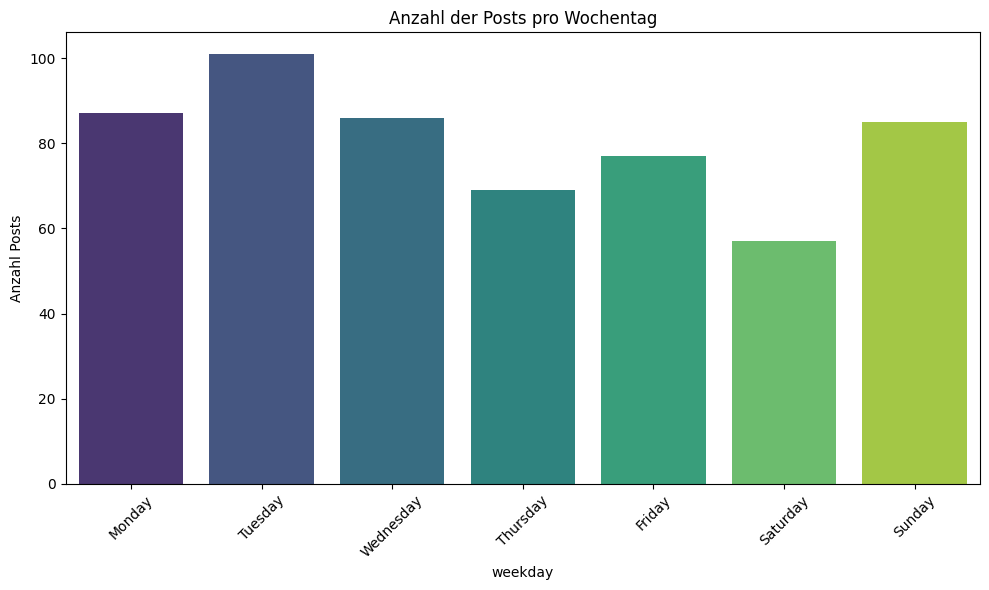

In [34]:
# 1. Balkendiagramm: Anzahl Posts pro Wochentag
posts = session.query(Post).all()
df_posts = pd.DataFrame([{
    'id': p.id,
    'date_local': p.date_local,
    'content_type': p.content_type,
    'like_count': p.like_count or 0,
    'comment_count': p.comment_count or 0,
    'caption_hashtags': p.caption_hashtags or [],
    'caption_mentions': p.caption_mentions or [] 
} for p in posts])

df_posts['weekday'] = df_posts['date_local'].dt.day_name()
weekday_counts = df_posts['weekday'].value_counts().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
).fillna(0)

plt.figure(figsize=(10,6))
sns.barplot(x=weekday_counts.index, y=weekday_counts.values, palette='viridis')
plt.title('Anzahl der Posts pro Wochentag')
plt.ylabel('Anzahl Posts')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


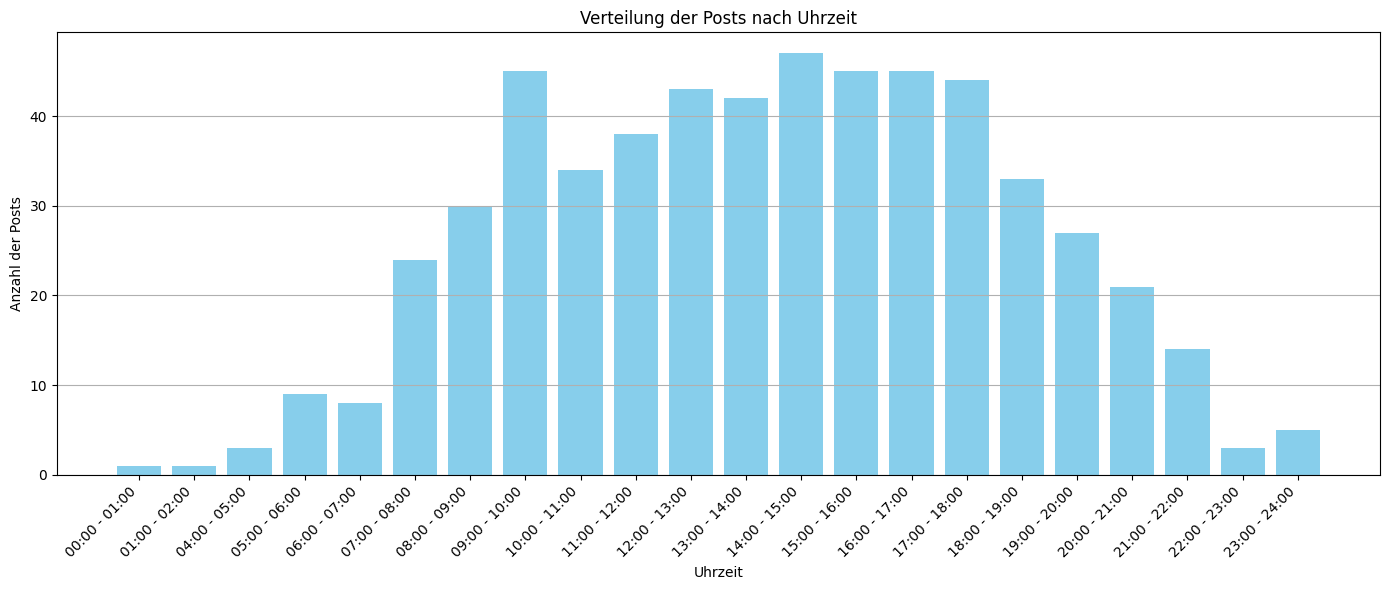

In [65]:
import matplotlib.pyplot as plt

# Stelle sicher, dass 'date_local' ein datetime-Objekt ist
df_posts['date_local'] = pd.to_datetime(df_posts['date_local'])

# Stunde extrahieren
df_posts['hour'] = df_posts['date_local'].dt.hour

# Gruppieren nach Stunde
post_counts_per_hour = df_posts['hour'].value_counts().sort_index()

# Achsenlabels generieren
labels = [f"{h:02d}:00 - {h+1:02d}:00" for h in post_counts_per_hour.index]

plt.figure(figsize=(14, 6))  # Breiter machen
plt.bar(labels, post_counts_per_hour.values, color='skyblue')
plt.xlabel('Uhrzeit')
plt.ylabel('Anzahl der Posts')
plt.title('Verteilung der Posts nach Uhrzeit')

plt.xticks(rotation=45, ha='right')  # 45°-Drehung, nach rechts geneigt
plt.tight_layout()  # Vermeidet Abschneiden
plt.grid(axis='y')
plt.show()



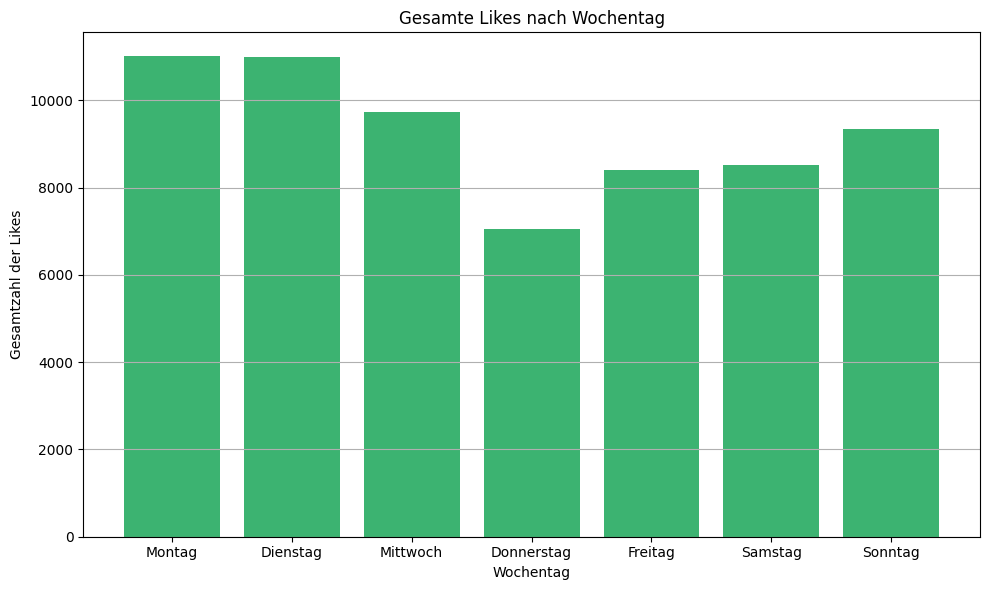

In [66]:
import matplotlib.pyplot as plt

# Stelle sicher, dass 'date_local' ein datetime-Objekt ist
df_posts['date_local'] = pd.to_datetime(df_posts['date_local'])

# Wochentag extrahieren (0 = Montag, 6 = Sonntag)
df_posts['weekday'] = df_posts['date_local'].dt.dayofweek

# Optional: Namen der Wochentage
weekday_labels = ['Montag', 'Dienstag', 'Mittwoch', 'Donnerstag', 'Freitag', 'Samstag', 'Sonntag']

# Likes summieren pro Wochentag
likes_per_weekday = df_posts.groupby('weekday')['like_count'].sum().reindex(range(7))

# Plot
plt.figure(figsize=(10, 6))
plt.bar(weekday_labels, likes_per_weekday.values, color='mediumseagreen')
plt.xlabel('Wochentag')
plt.ylabel('Gesamtzahl der Likes')
plt.title('Gesamte Likes nach Wochentag')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


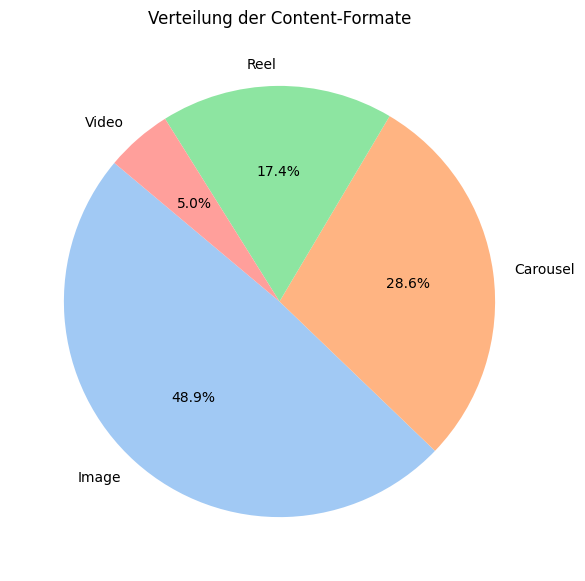

In [28]:
# 2. Kuchendiagramm: Verteilung Content-Format
content_counts = df_posts['content_type'].value_counts()
plt.figure(figsize=(7,7))
plt.pie(content_counts, labels=content_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Verteilung der Content-Formate')
plt.show()

/tmp/ipykernel_27796/2961406855.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=likes_pct.index, y=likes_pct.values, palette='mako')


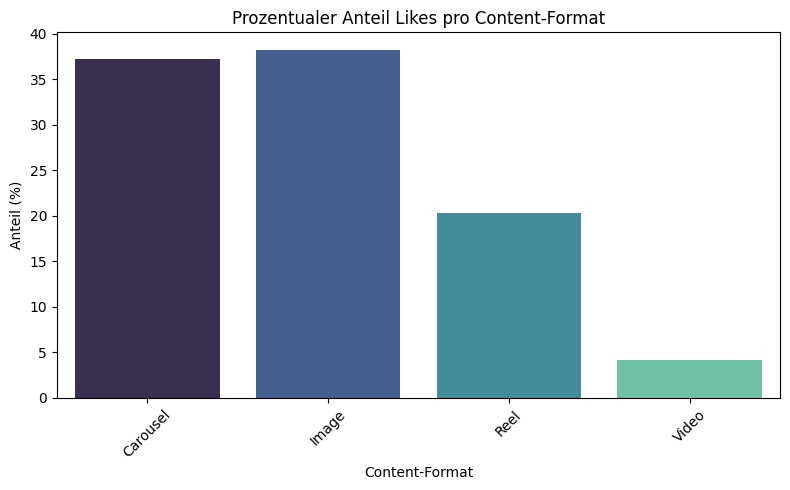

In [29]:
# 3. Prozentualer Anteil Likes pro Content-Format
likes_by_format = df_posts.groupby('content_type')['like_count'].sum()
likes_pct = (likes_by_format / likes_by_format.sum()) * 100
plt.figure(figsize=(8,5))
sns.barplot(x=likes_pct.index, y=likes_pct.values, palette='mako')
plt.title('Prozentualer Anteil Likes pro Content-Format')
plt.ylabel('Anteil (%)')
plt.xlabel('Content-Format')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/tmp/ipykernel_27796/3854207478.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=comments_pct.index, y=comments_pct.values, palette='rocket')


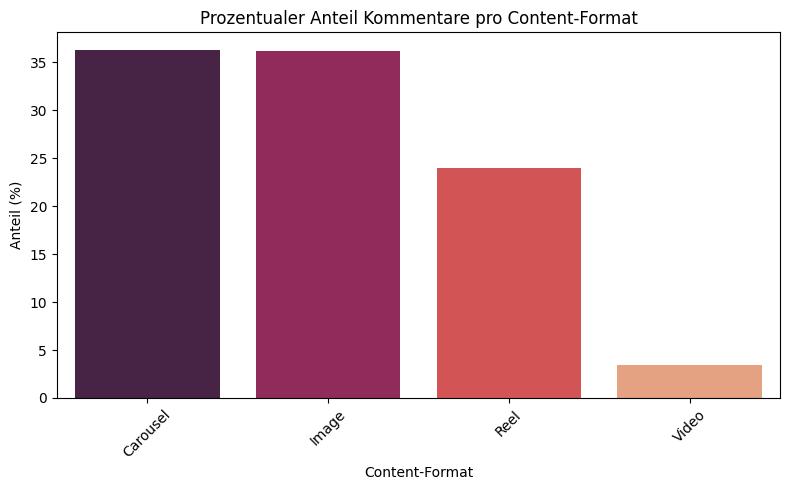

In [30]:
# 4. Prozentualer Anteil Kommentare pro Content-Format
comments_by_format = df_posts.groupby('content_type')['comment_count'].sum()
comments_pct = (comments_by_format / comments_by_format.sum()) * 100
plt.figure(figsize=(8,5))
sns.barplot(x=comments_pct.index, y=comments_pct.values, palette='rocket')
plt.title('Prozentualer Anteil Kommentare pro Content-Format')
plt.ylabel('Anteil (%)')
plt.xlabel('Content-Format')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/tmp/ipykernel_27796/358380227.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(hashtags), palette='cubehelix')


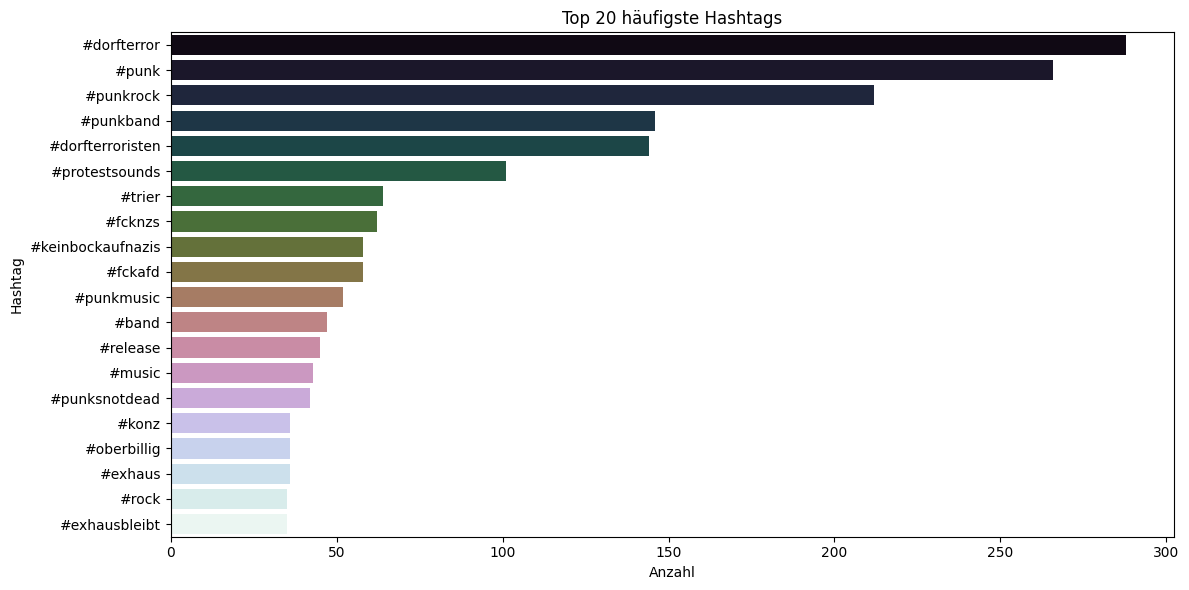

In [31]:
# 5. Häufigste Hashtags (Top 20)
all_hashtags = [hashtag.lower() for hashtags in df_posts['caption_hashtags'] for hashtag in (hashtags if hashtags else [])]
top_hashtags = Counter(all_hashtags).most_common(20)
hashtags, counts = zip(*top_hashtags)

plt.figure(figsize=(12,6))
sns.barplot(x=list(counts), y=list(hashtags), palette='cubehelix')
plt.title('Top 20 häufigste Hashtags')
plt.xlabel('Anzahl')
plt.ylabel('Hashtag')
plt.tight_layout()
plt.show()


Fehler bei dorfterror: 403 Client Error: Forbidden for url: https://scontent-cdg4-2.cdninstagram.com/v/t51.2885-19/468566340_1080483403382431_3800128179714413222_n.jpg?stp=dst-jpg_s320x320_tt6&_nc_ht=scontent-cdg4-2.cdninstagram.com&_nc_cat=107&_nc_oc=Q6cZ2QFMtMF9zvB5aECEDFIfajeSOdMxUHq0yUwvOmNfYOK4wKUQZhe8WiFCR8wg6eJHHgI&_nc_ohc=cl_x3tc0wvgQ7kNvwH6iRrq&_nc_gid=ptLv-dxArep7DJ6QsyiUdA&edm=AOQ1c0wBAAAA&ccb=7-5&oh=00_AfRtmoUvuBlid_D_dP8QtIY88V6xwYBt1Ckz2tPl6nJk1g&oe=68746D70&_nc_sid=8b3546


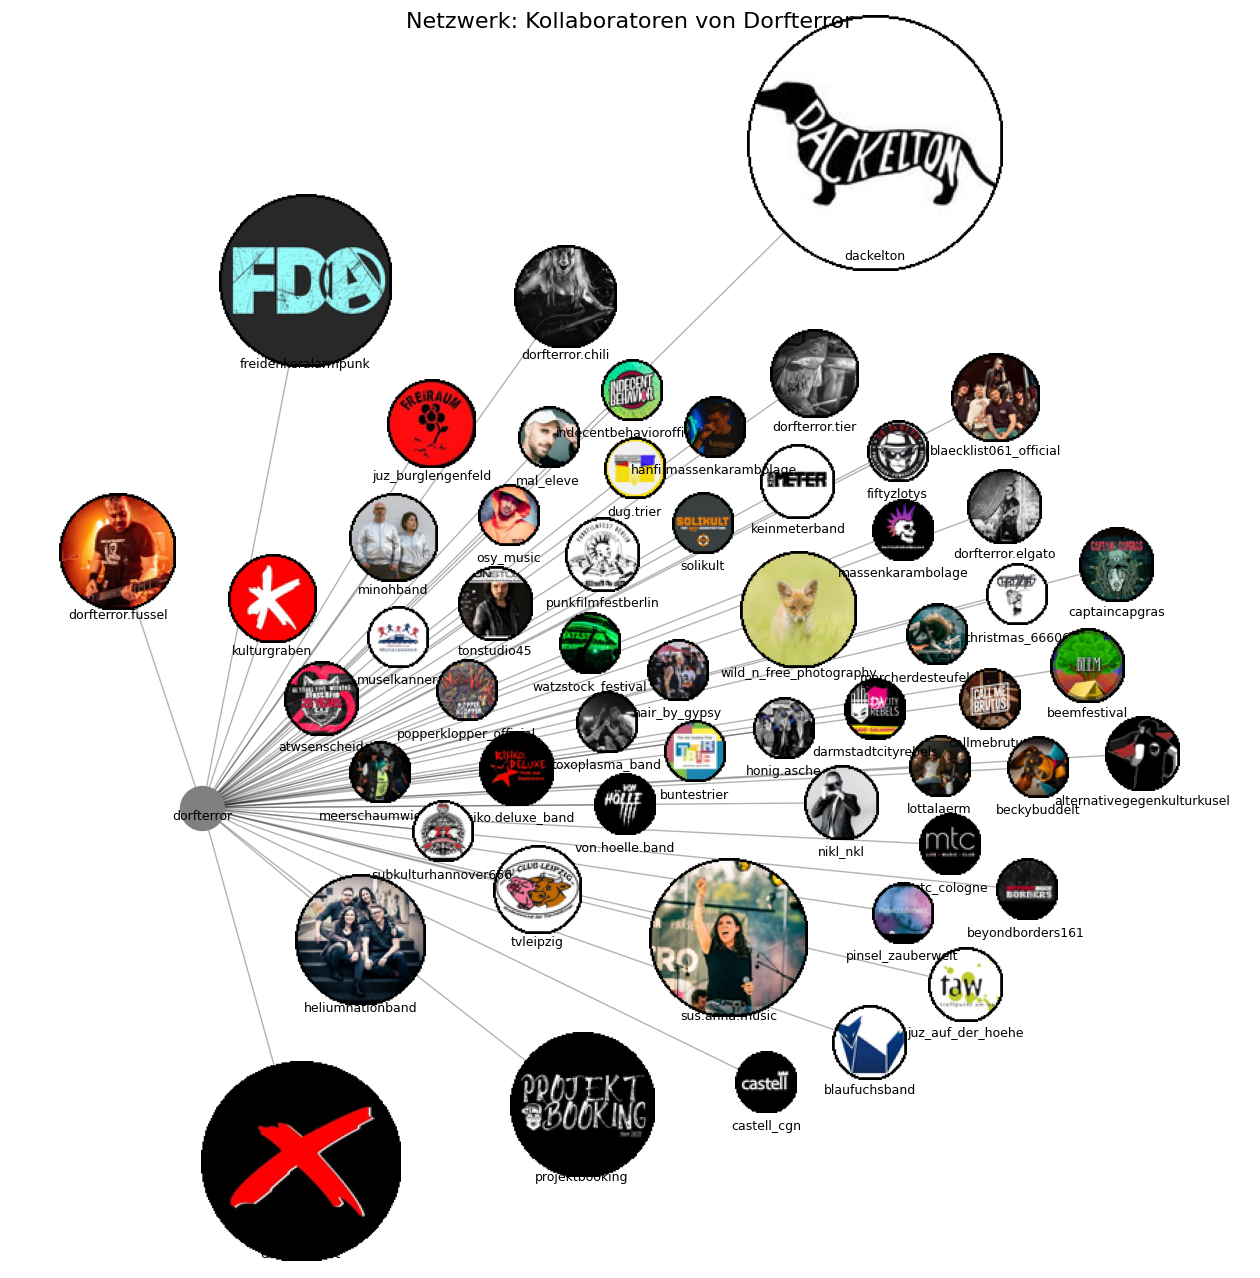

In [62]:
# 6. Netzwerkdiagramm: Dorfterror in Mitte, Kollaboratoren als Knoten mit Profilbildern
# Dorfterror Profil laden
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from PIL import Image, ImageDraw
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import numpy as np

dorfterror_profile = session.query(Profile).filter(Profile.username == 'dorfterror').first()

# Alle Kollaborationen von Dorfterror laden
dorfterror_post_ids = [
    p.id for p in session.query(Post).filter(Post.user_posted == dorfterror_profile.username)
]

collabs = session.query(Collaborator).filter(Collaborator.post_id.in_(dorfterror_post_ids)).all()

# Zähle, wie oft jeder Kollaborator mit Dorfterror zusammenarbeitet
collab_counts = Counter([c.profile_id for c in collabs])

# Profilinfos laden
collab_profiles = session.query(Profile).filter(Profile.id.in_(list(collab_counts.keys()))).all()
id_to_profile = {p.id: p for p in collab_profiles}

# Netzwerk erstellen
G = nx.Graph()
G.add_node(dorfterror_profile.username, size=1000, image_url=dorfterror_profile.profile_image_link)

# Knoten für Kollaboratoren hinzufügen
for collab_id, count in collab_counts.items():
    profile = id_to_profile.get(collab_id)
    if profile:
        G.add_node(profile.username, size=300 + count * 100, image_url=profile.profile_image_link)
        G.add_edge(dorfterror_profile.username, profile.username)


# Layout mit mehr Platz
#pos = nx.spring_layout(G, k=1.2, seed=42)

import numpy as np

def get_distance(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))

def resolve_overlaps(pos, sizes, min_dist_factor=1.2, max_iter=200):
    """
    Verschiebt Knoten, falls sie sich basierend auf ihrer Bildgröße überlappen.
    """
    for _ in range(max_iter):
        moved = False
        for n1 in pos:
            for n2 in pos:
                if n1 == n2:
                    continue
                p1, p2 = np.array(pos[n1]), np.array(pos[n2])
                dist = get_distance(p1, p2)
                min_dist = (sizes[n1] + sizes[n2]) * min_dist_factor / 20  # Skalierung für Abstand

                if dist < min_dist:
                    # Richtung berechnen, um Knoten zu verschieben
                    direction = (p1 - p2) / (dist + 1e-5)
                    shift = (min_dist - dist) / 2
                    pos[n1] = tuple(p1 + direction * shift)
                    pos[n2] = tuple(p2 - direction * shift)
                    moved = True
        if not moved:
            break
    return pos


# Schritt 1: Zentrum setzen
center_node = dorfterror_profile.username
pos = {center_node: (0, 0)}

# Schritt 2: Kollaboratoren radial verteilen
other_nodes = [n for n in G.nodes if n != center_node]
num_nodes = len(other_nodes)
angle_step = 2 * np.pi / num_nodes

# Maximale Knotengröße für Radiusberechnung
max_size = max(G.nodes[n]["size"] for n in other_nodes)
sizes = {n: G.nodes[n]["size"] / 10 for n in G.nodes}  # Bildgröße zur Abstandskalkulation

# Erste Platzierung
for i, node in enumerate(sorted(other_nodes)):
    angle = i * angle_step
    size = G.nodes[node]["size"]
    radius = 2 + 4 * (size / max_size)
    x = np.cos(angle) * radius
    y = np.sin(angle) * radius
    pos[node] = (x, y)

# Schritt 3: Überlappungen korrigieren
pos = resolve_overlaps(pos, sizes)



plt.figure(figsize=(16, 16))
ax = plt.gca()
nx.draw_networkx_edges(G, pos, alpha=0.3)

for node in G.nodes:
    x, y = pos[node]
    node_size = G.nodes[node]['size']
    img_url = G.nodes[node].get('image_url') or "https://via.placeholder.com/150"

    try:
        headers = {
            "User-Agent": "Mozilla/5.0"
        }
        response = requests.get(img_url, headers=headers, timeout=5)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content)).convert("RGBA")

        size = int(node_size / 10)
        img = img.resize((size, size), Image.LANCZOS)

        # Runde Maske
        mask = Image.new('L', (size, size), 0)
        draw_mask = ImageDraw.Draw(mask)
        draw_mask.ellipse((0, 0, size, size), fill=255)

        # Dünner schwarzer Rand
        border_size = 2  # SCHMALER gemacht
        bordered_img = Image.new("RGBA", (size + 2 * border_size, size + 2 * border_size), (0, 0, 0, 0))
        border_draw = ImageDraw.Draw(bordered_img)
        border_draw.ellipse(
            (0, 0, size + 2 * border_size, size + 2 * border_size),
            fill=(0, 0, 0, 255)  # schwarzer Rand
        )

        # Bild mit runder Maske einfügen
        img.putalpha(mask)
        bordered_img.paste(img, (border_size, border_size), img)

        # Anzeige als runder Knoten mit dünnem Rand
        img_box = OffsetImage(bordered_img, zoom=1)
        ab = AnnotationBbox(img_box, (x, y), frameon=False)
        ax.add_artist(ab)

        # Dynamischer Abstand basierend auf tatsächlicher Bildhöhe in Datenkoordinaten
        fig = plt.gcf()
        ax = plt.gca()
        bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        ax_width, ax_height = bbox.width, bbox.height

        # Größe des Bildes in Datenkoordinaten (grob geschätzt)
        scale = ax.transData.inverted().transform([(0, 0), (0, size)])
        dy = abs(scale[1][1] - scale[0][1])

        plt.text(x, y - dy / 2 - 1, node, ha='center', va='top', fontsize=9)


    except Exception as e:
        print(f"Fehler bei {node}: {e}")
        # Fallback: grauer Kreis und Text
        nx.draw_networkx_nodes(G, pos, nodelist=[node], node_size=node_size, node_color='gray', ax=ax)
        plt.text(x, y - 0.1, node, ha='center', va='top', fontsize=9)


plt.title('Netzwerk: Kollaboratoren von Dorfterror', fontsize=16)
plt.axis('off')
plt.show()

/tmp/ipykernel_27796/177107584.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(mention_counts), y=list(mention_names), palette='coolwarm')


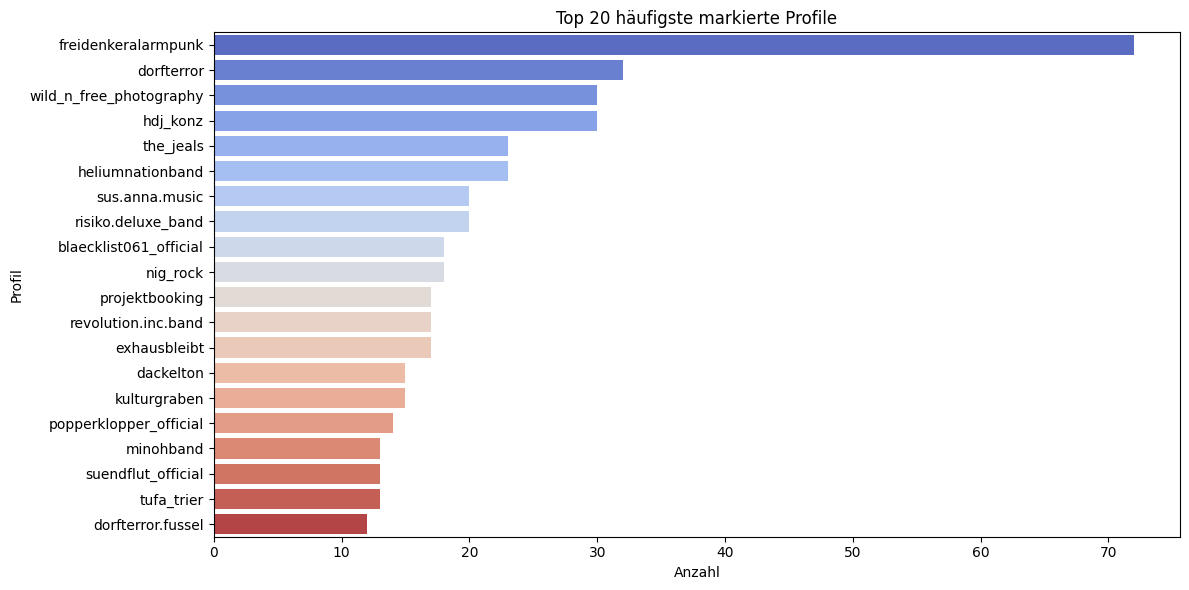

In [35]:
# 7. Diagramm häufigste markierte Profile (caption_mentions)
mentions = [mention.lower() for mentions_list in df_posts['caption_mentions'] for mention in (mentions_list if mentions_list else [])]
top_mentions = Counter(mentions).most_common(20)
mention_names, mention_counts = zip(*top_mentions)

plt.figure(figsize=(12,6))
sns.barplot(x=list(mention_counts), y=list(mention_names), palette='coolwarm')
plt.title('Top 20 häufigste markierte Profile')
plt.xlabel('Anzahl')
plt.ylabel('Profil')
plt.tight_layout()
plt.show()

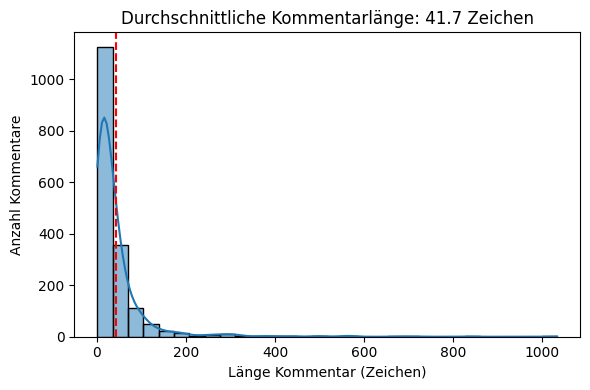

In [36]:
# 8. Durchschnittliche Kommentarlänge
comments = session.query(Comment).filter(Comment.text != None).all()
df_comments = pd.DataFrame([{
    'text_length': len(c.text),
    'post_id': c.post_id
} for c in comments])

avg_comment_length = df_comments['text_length'].mean()

plt.figure(figsize=(6,4))
sns.histplot(df_comments['text_length'], bins=30, kde=True)
plt.axvline(avg_comment_length, color='red', linestyle='--')
plt.title(f'Durchschnittliche Kommentarlänge: {avg_comment_length:.1f} Zeichen')
plt.xlabel('Länge Kommentar (Zeichen)')
plt.ylabel('Anzahl Kommentare')
plt.tight_layout()
plt.show()

/tmp/ipykernel_27796/1705084154.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_comments_format.index, y=avg_comments_format.values, palette='magma')


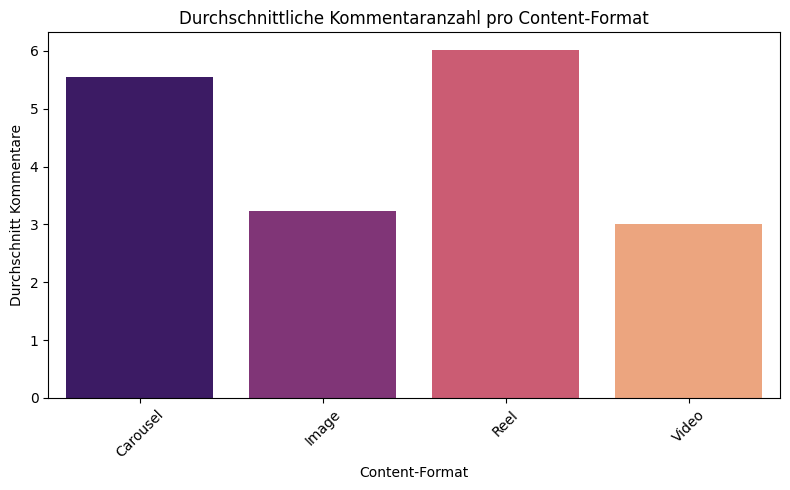

In [37]:
# 9. Durchschnittliche Kommentaranzahl pro Content-Format
# Posts mit Content-Format & comment_count schon in df_posts
avg_comments_format = df_posts.groupby('content_type')['comment_count'].mean()

plt.figure(figsize=(8,5))
sns.barplot(x=avg_comments_format.index, y=avg_comments_format.values, palette='magma')
plt.title('Durchschnittliche Kommentaranzahl pro Content-Format')
plt.ylabel('Durchschnitt Kommentare')
plt.xlabel('Content-Format')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Man gibt ihm Kontext "Wir haben eine Single die bald raus kommt". Das Modell erkennt um welche Kategorie es geht und zieht sich die top X Captions und schreibt basierend daurauf einen Text. Es sollen gemeinsame Hashtags vorgeschlagen werden

Agent verbindet sich mit anderen Profilen und schlägt automatisch posts (nach Konzerten) vor oder kann das basierend auf einem release plan

Wie viele Follower haben unsere Follower; andere interessante allgemeine Facts